# Run ensemble model and submit predictions

### Imports

In [25]:
import os
if 'notebooks' in os.getcwd():
    os.chdir('../..')  # change to main directory
if "adrian_sensorium" not in os.getcwd():
    os.chdir("adrian_sensorium")

print('Working directory:', os.getcwd())

Working directory: c:\Users\asimo\Documents\BCCN\Lab Rotations\Petreanu Lab\adrian_sensorium


In [26]:
from sensorium.utility.training import read_config
from sensorium.utility import submission
from nnfabrik.builder import get_data, get_model, get_trainer
import torch

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.auto import tqdm


import warnings

warnings.filterwarnings('ignore')

### Load configuration for model

In [27]:
# Loading config only for ensemble 0, because all 5 models have the same config (except
# for the seed and dataloader train/validation split)

config_file = 'notebooks/submission_m4/config_m4_ens0.yaml'
config = read_config(config_file)
print(config)

{'data_sets': ['all'], 'dataset_fn': 'sensorium.datasets.static_loaders', 'dataset_config': {'normalize': True, 'include_behavior': True, 'include_eye_position': True, 'batch_size': 128, 'scale': 0.25, 'preload_from_merged_data': True, 'include_trial_id': True, 'include_rank_id': True, 'include_history': True, 'include_behav_state': True, 'adjusted_normalization': True, 'use_ensemble_tier': True, 'ensemble_nr': 0}, 'model_fn': 'sensorium.models.modulated_stacked_core_full_gauss_readout', 'model_seed': 100, 'model_config': {'pad_input': False, 'stack': -1, 'layers': 4, 'input_kern': 9, 'gamma_input': 9.8, 'gamma_readout': 0.48, 'hidden_kern': 10, 'hidden_channels': 64, 'depth_separable': True, 'grid_mean_predictor': {'type': 'cortex', 'input_dimensions': 2, 'hidden_layers': 4, 'hidden_features': 20, 'nonlinearity': 'ReLU', 'final_tanh': True}, 'init_sigma': 0.14, 'init_mu_range': 0.8, 'gauss_type': 'full', 'shifter': True, 'with_modulator': True, 'modulator_type': 'HistoryStateGain', 'm

### Prepare dataloader

In [28]:
# Use only one dataloader, since test and final_test are the same for all ensembles
# basepath = "notebooks/data/"
# filenames = [os.path.join(basepath, file) for file in os.listdir(basepath) if ".zip" in file ]
# filenames = [file for file in filenames if 'static26872-17-20' not in file]

basepath = "notebooks/data/IM_prezipped"
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
# Second level
folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
folders

['notebooks/data/IM_prezipped/LPE11086/2023_12_16']

In [29]:
dataset_fn = config['dataset_fn']  # 'sensorium.datasets.static_loaders'
dataset_config = {'paths': folders,  # filenames,
                  **config['dataset_config'],
                  }

dataloaders = get_data(dataset_fn, dataset_config)

### Load trained models

In [30]:
# Instantiate all five models
model_list = list()

for i in tqdm(range(5)):
    # all models have the same parameters
    # e.g. 'sensorium.models.modulated_stacked_core_full_gauss_readout'
    model_fn = config['model_fn']
    model_config = config['model_config']

    model = get_model(model_fn=model_fn,
                      model_config=model_config,
                      dataloaders=dataloaders,
                      seed=config['model_seed'],
                      )

    # Load trained weights from specific ensemble
    save_file = 'saved_models/config_m4_ens{}/saved_model_v1.pth'.format(i)
    model.load_state_dict(torch.load(save_file))
    model_list.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

### Combine them into one ensemble model

In [31]:
from sensorium.models.ensemble import EnsemblePrediction

In [32]:
ensemble = EnsemblePrediction(model_list, mode='mean')

In [33]:
type(model_list[0])

neuralpredictors.layers.encoders.firing_rate.ModulatedFiringRateEncoder

### Generate submission file

In [34]:
# dataset_name = '27204-5-13'

# submission.generate_submission_file(trained_model=ensemble, 
#                                     dataloaders=dataloaders,
#                                     data_key=dataset_name,
#                                     path="notebooks/submission_m4/results/",
#                                     device="cuda")

### Evaluate model on all datasets

In [35]:
from sensorium.utility import get_correlations, get_signal_correlations, get_fev
from sensorium.utility.measure_helpers import get_df_for_scores

#### Test data

In [36]:
tier = "validation"

single_trial_correlation = get_correlations(
    ensemble, dataloaders, tier=tier, device="cuda", as_dict=True)

df = get_df_for_scores(session_dict=single_trial_correlation,
                       measure_attribute="Single Trial Correlation"
                       )

In [37]:
for k in dataloaders[tier]:
    assert len(df[df['dataset'] == k]) == len(dataloaders[tier][k].dataset.neurons.area), "Length of df and dataloader not equal"
    df.loc[df['dataset'] == k, 'area'] = dataloaders[tier][k].dataset.neurons.area

In [38]:
data_basepath = "../molanalysis/data/IM/"

for k in dataloaders[tier]:
    data_path = os.path.join(data_basepath, k.split('-')[1].split('_')[0] + '/' + '_'.join(k.split('-')[1].split('_')[1:]))
    celldata = pd.read_csv(data_path + '/celldata.csv')
    assert len(df[df['dataset'] == k]) == len(celldata), "Length of df and celldata not equal"
    df.loc[df['dataset'] == k, 'labeled'] = celldata['redcell'].astype(bool).values

In [39]:
%matplotlib inline

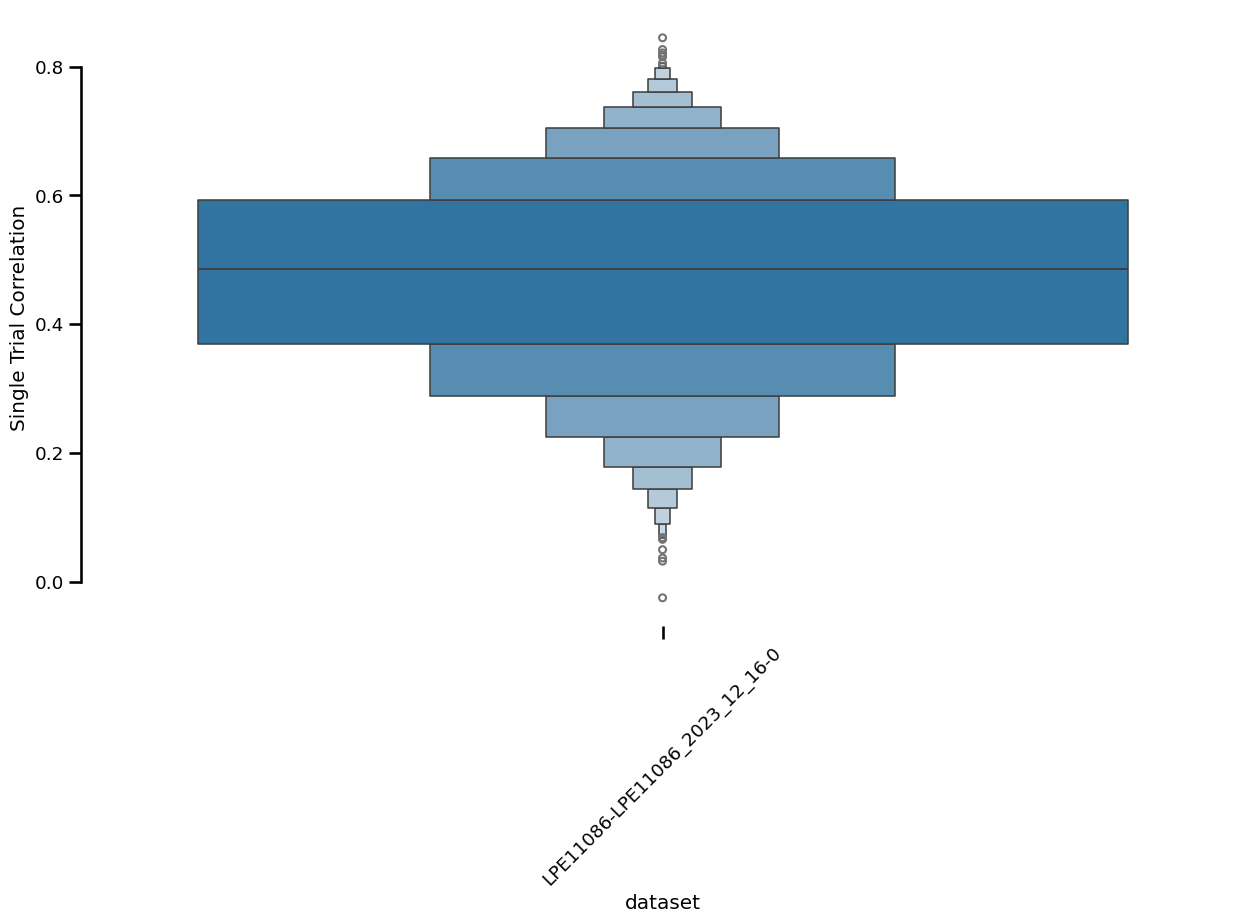

In [40]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15, 8))
sns.boxenplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation=45)
sns.despine(trim=True)

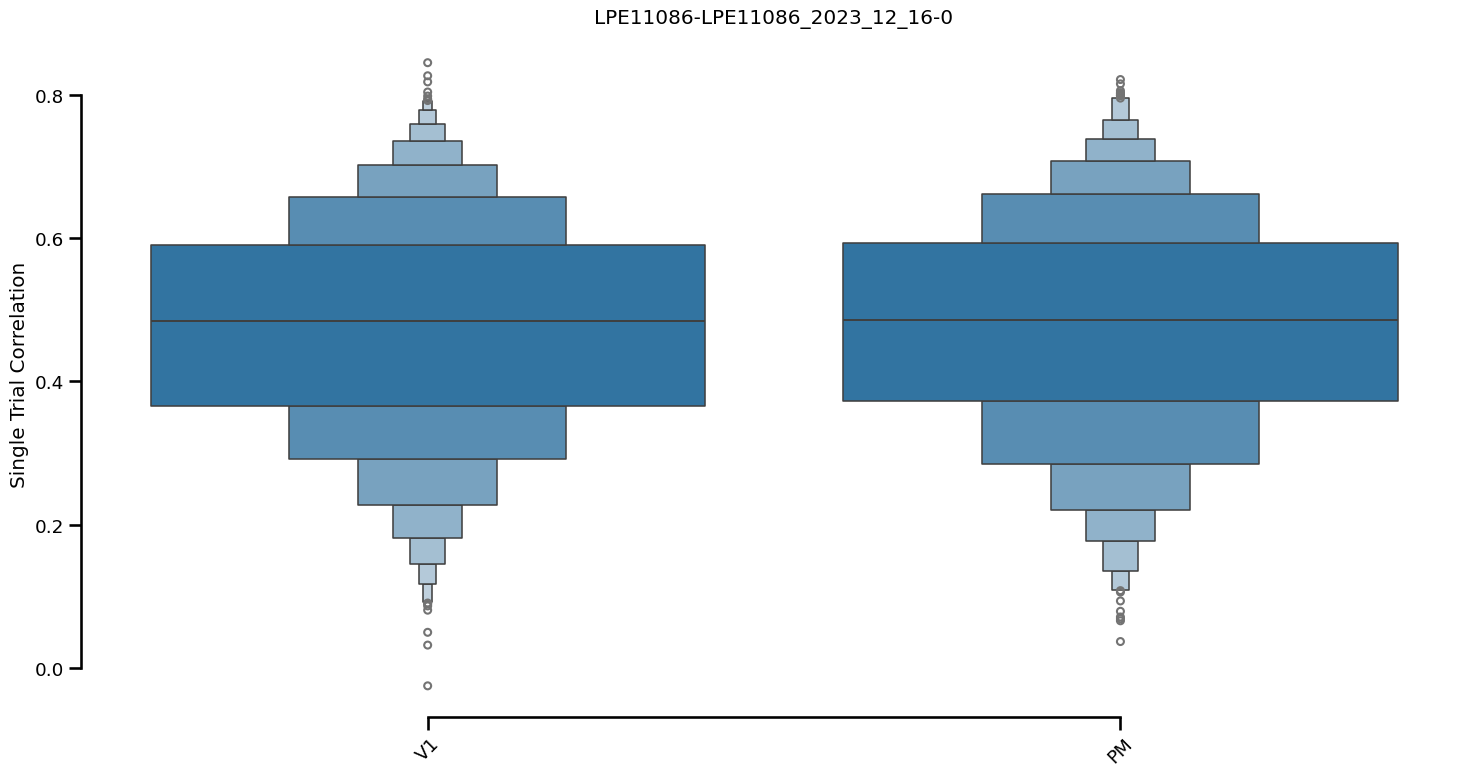

In [41]:
sns.set_context("talk", font_scale=.8)
fig, axes = plt.subplots(nrows=1, ncols=len(df['dataset'].unique()), figsize=(15, 8), sharey=True)

for idx, (ax, (i, g)) in enumerate(zip(np.array(axes).reshape(-1), df.sort_values('area', ascending = False).groupby('dataset'))):
    sns.boxenplot(x="area", y="Single Trial Correlation", data=g, ax=ax)
    ax.set_title(i)  # Set the title of each subplot to the dataset name
    ax.set_xlabel("")  # Set the x-axis label
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) 

    if idx > 0:
        # remove y axis line
        ax.spines['left'].set_visible(False)
        ax.set_ylabel("")
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.get_yaxis().set_visible(False)

        for spine in ax.spines.values():
            spine.set_visible(False)            

sns.despine(trim=True)
plt.tight_layout()
plt.show()

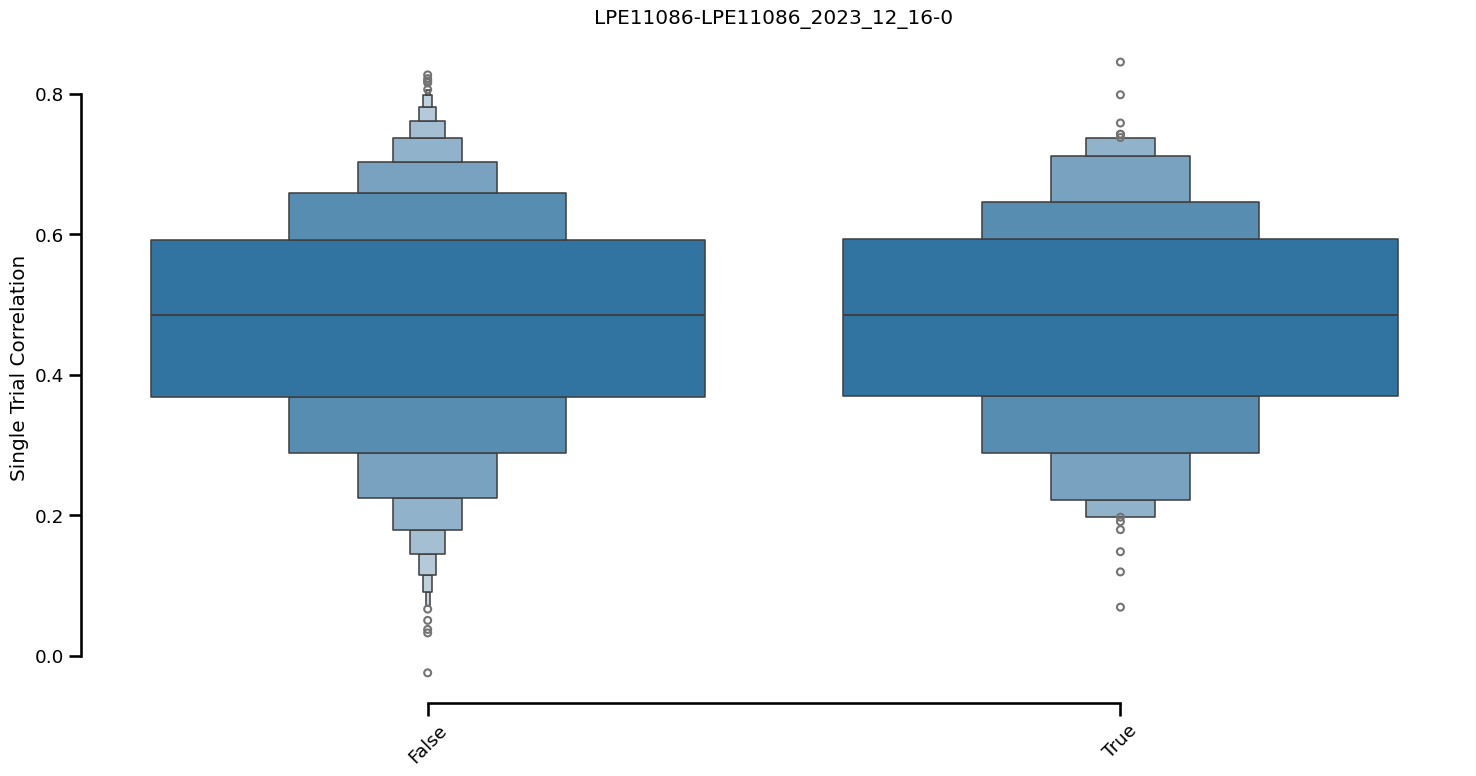

In [42]:
sns.set_context("talk", font_scale=.8)
fig, axes = plt.subplots(nrows=1, ncols=len(df['dataset'].unique()), figsize=(15, 8), sharey=True)

for idx, (ax, (i, g)) in enumerate(zip(np.array(axes).reshape(-1), df.sort_values('labeled', ascending = False).groupby('dataset'))):
    sns.boxenplot(x="labeled", y="Single Trial Correlation", data=g, ax=ax)
    ax.set_title(i)  # Set the title of each subplot to the dataset name
    ax.set_xlabel("")  # Set the x-axis label
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45) 

    if idx > 0:
        # remove y axis line
        ax.spines['left'].set_visible(False)
        ax.set_ylabel("")
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.get_yaxis().set_visible(False)

        for spine in ax.spines.values():
            spine.set_visible(False)            

sns.despine(trim=True)
plt.tight_layout()
plt.show()

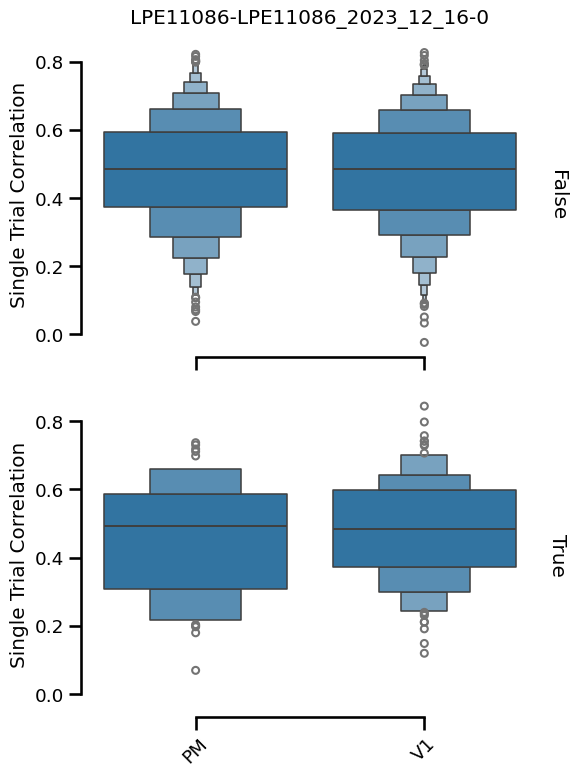

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk", font_scale=.8)

# Create a FacetGrid to split the data by 'dataset' and 'labeled'
g = sns.FacetGrid(df, col="dataset", row="labeled", margin_titles=True, height=4, aspect=1.5, sharey=True)

# Use boxenplot in each facet
g.map(sns.boxenplot, "area", "Single Trial Correlation")

# Adjust labels and titles
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_axis_labels("", "Single Trial Correlation")

# Rotate x-tick labels for better readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Adjust layout and remove extra spines
sns.despine(trim=True)
plt.tight_layout()
plt.show()


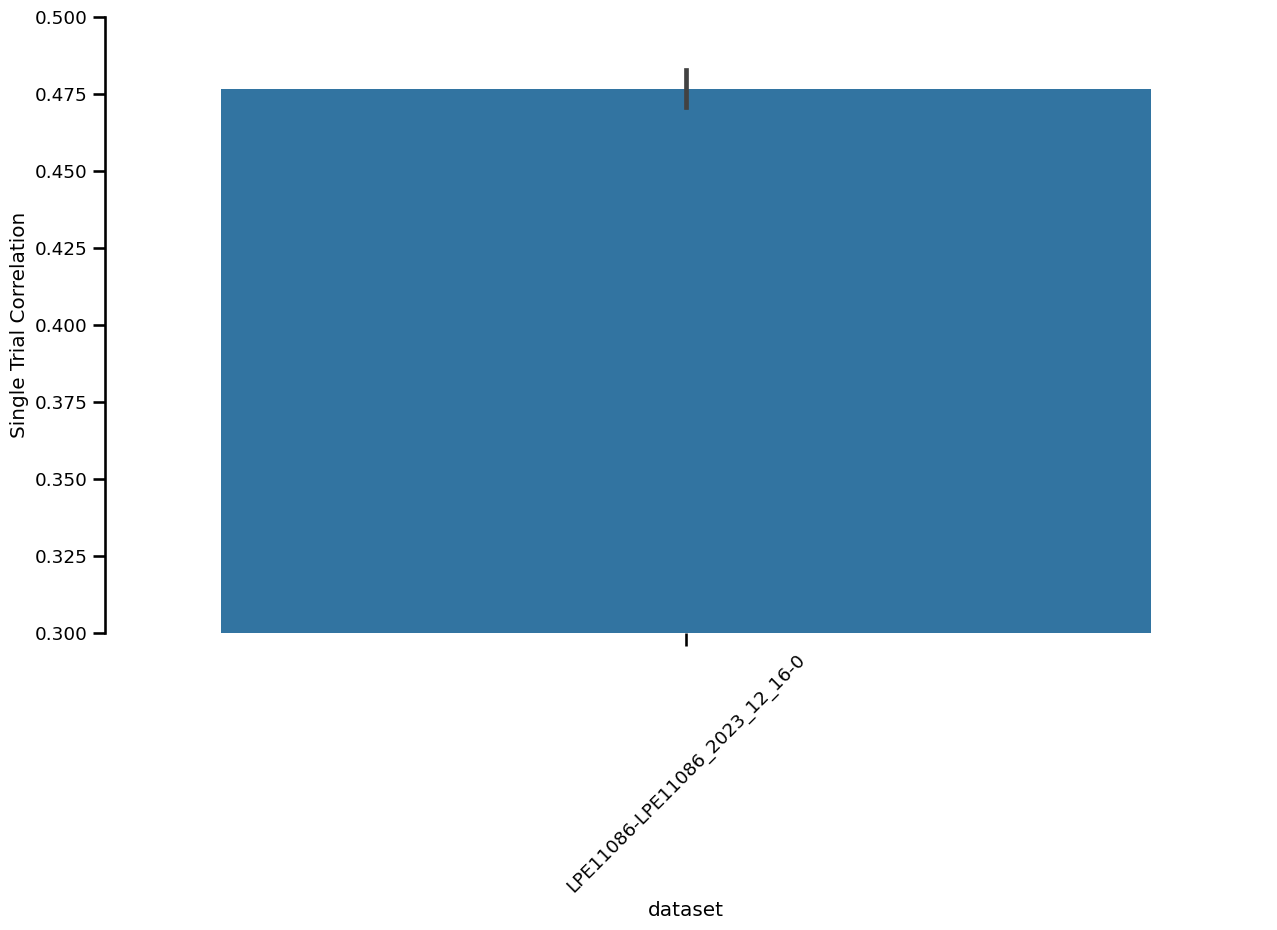

In [44]:
sns.set_context("talk", font_scale=.8)
fig = plt.figure(figsize=(15, 8))
sns.barplot(x="dataset", y="Single Trial Correlation", data=df, )
plt.xticks(rotation=45)
plt.ylim(0.3, 0.5)
sns.despine(trim=True)

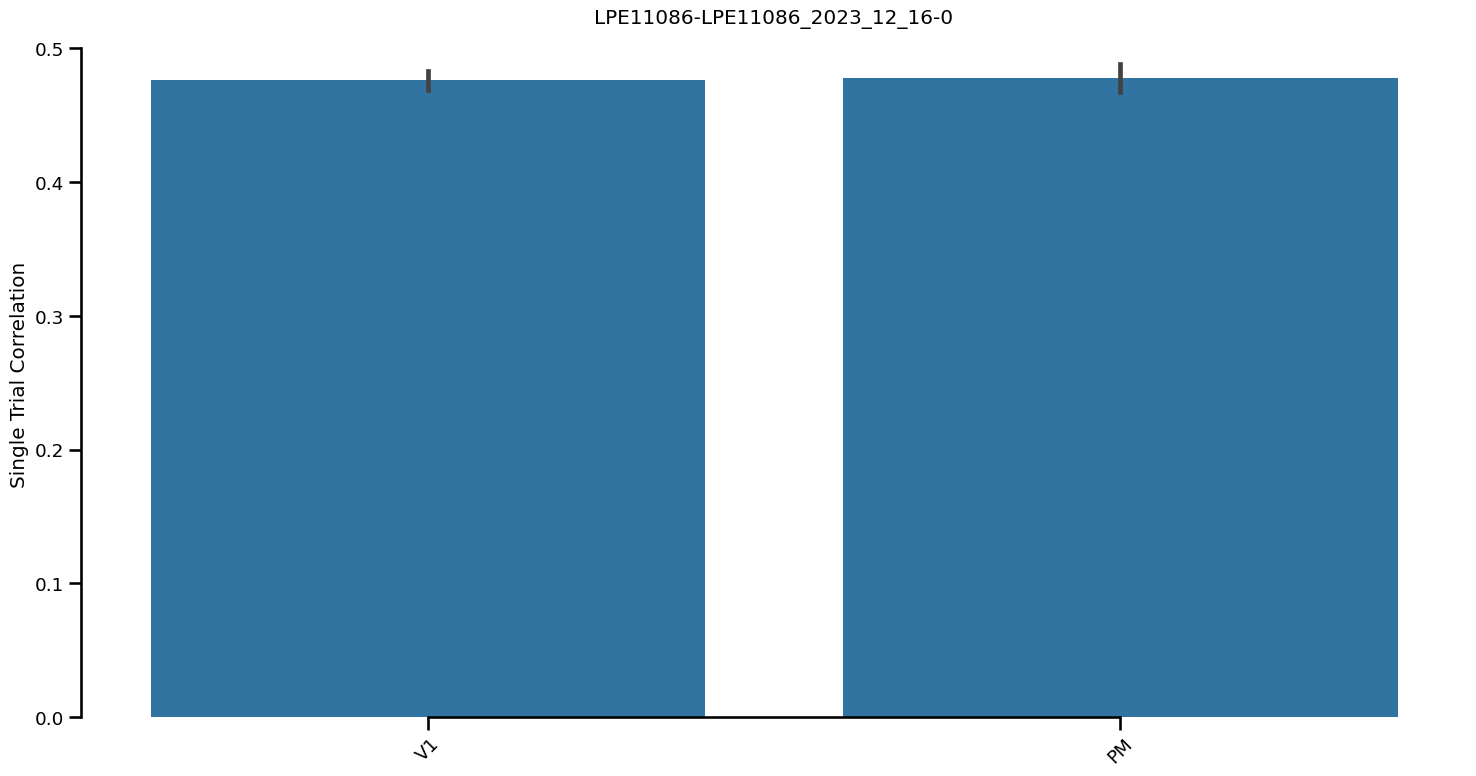

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=len(df['dataset'].unique()), figsize=(15, 8), sharey=True)

for ax, (i, g) in zip(np.array(axes).reshape(-1), df.sort_values("area", ascending=False).groupby('dataset')):
    sns.barplot(x="area", y="Single Trial Correlation", data=g, ax=ax)
    ax.set_title(i)  # Set the title of each subplot to the dataset name
    ax.set_xlabel("")  # Set the x-axis label
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

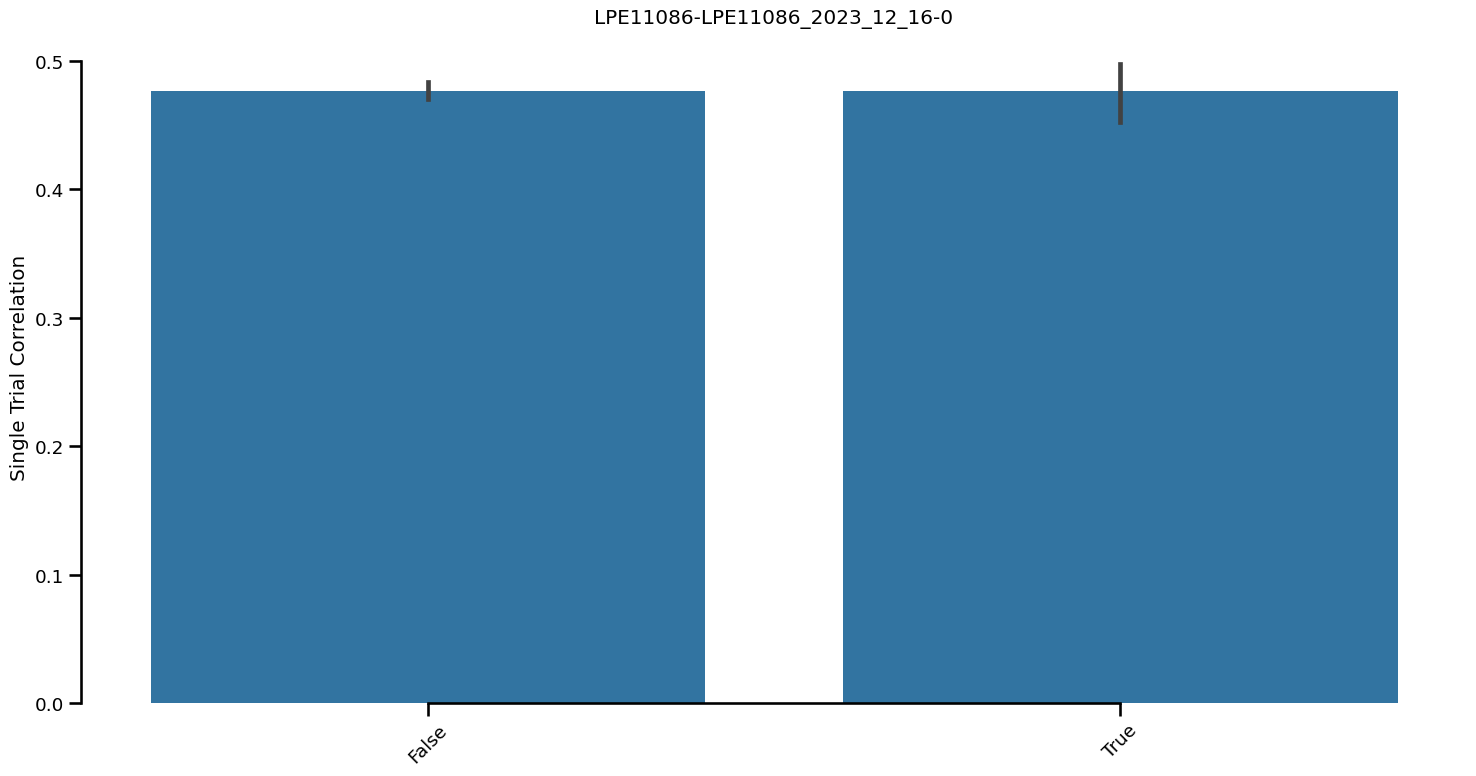

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=len(df['dataset'].unique()), figsize=(15, 8), sharey=True)

for ax, (i, g) in zip(np.array(axes).reshape(-1), df.sort_values("labeled", ascending=False).groupby('dataset')):
    sns.barplot(x="labeled", y="Single Trial Correlation", data=g, ax=ax)
    ax.set_title(i)  # Set the title of each subplot to the dataset name
    ax.set_xlabel("")  # Set the x-axis label
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

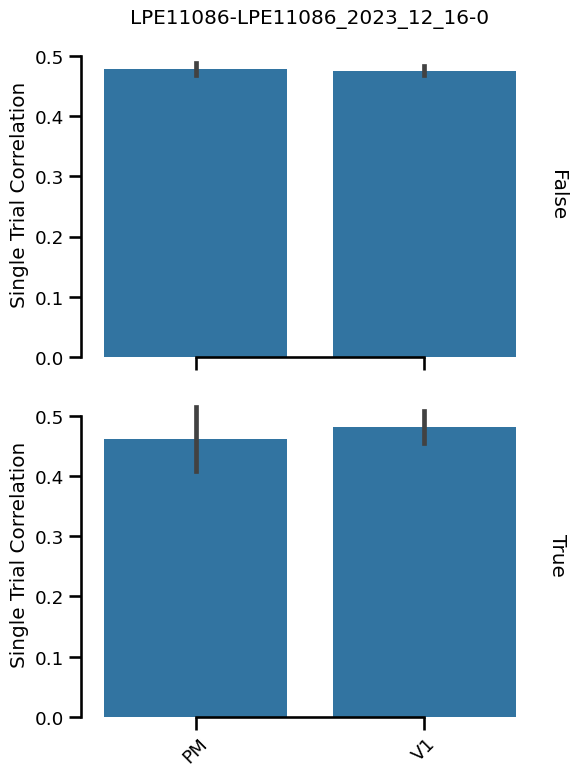

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk", font_scale=.8)

# Create a FacetGrid to split the data by 'dataset' and 'labeled'
g = sns.FacetGrid(df, col="dataset", row="labeled", margin_titles=True, height=4, aspect=1.5, sharey=True)

# Use boxenplot in each facet
g.map(sns.barplot, "area", "Single Trial Correlation")

# Adjust labels and titles
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_axis_labels("", "Single Trial Correlation")

# Rotate x-tick labels for better readability
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Adjust layout and remove extra spines
sns.despine(trim=True)
plt.tight_layout()
plt.show()


In [48]:
df_desc = df.groupby('dataset').describe()
df_desc.loc[("All datasets", )] = df_desc.mean()
# I'm so sorry about this horrible one liner
df_desc.loc[("All datasets, weighted"), ] = df_desc['Single Trial Correlation'].mul((df_desc['Single Trial Correlation']['count'].values.reshape(-1, 1)) / np.sum(df_desc['Single Trial Correlation']['count'].values)).sum().values
df_desc.to_csv('notebooks/submission_m4/results/validation_pred_description.csv', index = False)
df_desc

Single Trial Correlation                      \
                                                  count      mean       std   
dataset                                                                       
LPE11086-LPE11086_2023_12_16-0                   2585.0  0.476609  0.154124   
All datasets                                     2585.0  0.476609  0.154124   
All datasets, weighted                           2585.0  0.476609  0.154124   

                                                                        \
                                     min       25%       50%       75%   
dataset                                                                  
LPE11086-LPE11086_2023_12_16-0 -0.024687  0.368735  0.485053  0.592214   
All datasets                   -0.024687  0.368735  0.485053  0.592214   
All datasets, weighted         -0.024687  0.368735  0.485053  0.592214   

                                          
                                     max  
dataset                                   
LPE11086-LPE11086_2023_12_16-0  0.844767  
All datasets                    0.844767  
All datasets, weighted          0.844767

In [125]:
num_neurons = df_desc['Single Trial Correlation']['count'].iloc[0].astype(int)

In [128]:
mus = np.zeros((5, num_neurons, 2))
sigmas = np.zeros((5, num_neurons, 2, 2))

In [130]:
for i, model in enumerate(model_list):
    mus[i] = model.readout._modules['LPE11086-LPE11086_2023_12_16-0'].mu.detach().cpu().numpy().reshape(-1, 2)
    sigmas[i] = model.readout._modules['LPE11086-LPE11086_2023_12_16-0'].sigma.detach().cpu().numpy().reshape(-1, 2, 2)

In [178]:
df_neuron_stats = pd.DataFrame(columns=['dataset', 'neuron', 'mean', 'cov', 'mean_std', 'cov_std'] + [f'mean_{i}' for i in range(5)] + [f'cov_{i}' for i in range(5)])

df_neuron_stats['dataset'] = df['dataset']
df_neuron_stats['neuron'] = np.repeat(np.arange(num_neurons), len(df['dataset'].unique()))
for i in range(5):
    df_neuron_stats[f'mean_{i}'] = list(mus[i].round(2))
    df_neuron_stats[f'cov_{i}'] = list(sigmas[i].round(2))

df_neuron_stats['mean'] = list(mus.mean(axis=0).round(2))
df_neuron_stats['cov'] = list(sigmas.mean(axis=0).round(2))

df_neuron_stats['mean_std'] = list(mus.std(axis=0).round(2))
df_neuron_stats['cov_std'] = list(sigmas.std(axis=0).round(2))

In [180]:
df_neuron_stats.to_csv('notebooks/submission_m4/results/neuron_stats.csv', index = False)

In [181]:
df_neuron_stats

,dataset,neuron,mean,cov,mean_std,cov_std,mean_0,mean_1,mean_2,mean_3,mean_4,cov_0,cov_1,cov_2,cov_3,cov_4
0,LPE11086-LPE11086_2023_12_16-0,0,"[-0.2, 0.3]","[[-0.0, -0.0], [-0.0, 0.0]]","[0.15, 0.09]","[[0.01, 0.01], [0.0, 0.01]]","[-0.1, 0.23]","[-0.18, 0.27]","[-0.45, 0.36]","[-0.01, 0.18]","[-0.26, 0.44]","[[0.01, -0.01], [0.0, -0.0]]","[[0.0, -0.0], [-0.0, 0.01]]","[[0.01, -0.01], [-0.01, -0.01]]","[[-0.02, 0.02], [-0.0, 0.0]]","[[-0.02, -0.0], [0.01, -0.0]]"
1,LPE11086-LPE11086_2023_12_16-0,1,"[-0.03, 0.31]","[[0.0, -0.0], [-0.0, -0.0]]","[0.16, 0.1]","[[0.01, 0.01], [0.0, 0.01]]","[0.12, 0.22]","[-0.13, 0.28]","[-0.27, 0.37]","[0.16, 0.19]","[-0.05, 0.48]","[[0.01, -0.0], [0.0, 0.0]]","[[0.01, 0.01], [-0.01, -0.01]]","[[0.01, -0.01], [-0.01, -0.0]]","[[-0.01, -0.0], [0.0, 0.0]]","[[-0.01, -0.01], [-0.0, 0.0]]"
2,LPE11086-LPE11086_2023_12_16-0,2,"[-0.23, 0.29]","[[0.0, 0.0], [-0.0, -0.0]]","[0.16, 0.09]","[[0.01, 0.01], [0.0, 0.0]]","[-0.13, 0.24]","[-0.19, 0.27]","[-0.48, 0.35]","[-0.04, 0.18]","[-0.33, 0.43]","[[-0.0, -0.0], [-0.0, -0.01]]","[[0.0, -0.01], [0.0, -0.0]]","[[0.02, 0.0], [0.0, -0.0]]","[[0.0, 0.01], [0.0, -0.0]]","[[0.0, 0.0], [-0.01, -0.0]]"
3,LPE11086-LPE11086_2023_12_16-0,3,"[-0.04, 0.29]","[[-0.0, -0.0], [0.0, -0.0]]","[0.16, 0.09]","[[0.01, 0.01], [0.0, 0.0]]","[0.11, 0.23]","[-0.12, 0.24]","[-0.29, 0.35]","[0.14, 0.18]","[-0.06, 0.44]","[[0.0, 0.01], [0.0, -0.0]]","[[-0.01, -0.01], [-0.0, 0.0]]","[[-0.01, -0.02], [0.01, -0.01]]","[[0.0, 0.01], [-0.0, -0.0]]","[[0.01, 0.01], [0.0, 0.0]]"
4,LPE11086-LPE11086_2023_12_16-0,4,"[-0.01, 0.28]","[[-0.0, -0.0], [0.0, -0.01]]","[0.15, 0.1]","[[0.0, 0.01], [0.0, 0.01]]","[0.14, 0.23]","[-0.11, 0.24]","[-0.23, 0.35]","[0.16, 0.17]","[-0.03, 0.43]","[[-0.01, 0.0], [0.0, -0.0]]","[[-0.0, -0.01], [-0.0, -0.0]]","[[-0.0, -0.01], [0.0, -0.02]]","[[0.0, -0.0], [-0.0, 0.0]]","[[-0.0, 0.0], [-0.0, -0.01]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2580,LPE11086-LPE11086_2023_12_16-0,2580,"[-0.29, 0.29]","[[0.0, 0.0], [0.0, 0.0]]","[0.15, 0.09]","[[0.01, 0.01], [0.01, 0.01]]","[-0.21, 0.24]","[-0.2, 0.26]","[-0.54, 0.36]","[-0.11, 0.18]","[-0.4, 0.43]","[[0.0, 0.0], [0.0, 0.0]]","[[-0.0, -0.01], [0.01, 0.01]]","[[0.01, 0.01], [0.02, 0.01]]","[[0.0, -0.0], [0.0, -0.01]]","[[0.0, 0.0], [-0.01, -0.01]]"
2581,LPE11086-LPE11086_2023_12_16-0,2581,"[0.03, 0.28]","[[0.0, -0.0], [0.01, 0.0]]","[0.16, 0.1]","[[0.01, 0.01], [0.01, 0.01]]","[0.2, 0.22]","[-0.1, 0.23]","[-0.18, 0.34]","[0.2, 0.17]","[0.02, 0.44]","[[-0.01, -0.01], [0.01, 0.01]]","[[0.01, 0.0], [0.0, 0.0]]","[[0.02, -0.01], [0.02, -0.01]]","[[0.0, 0.0], [-0.01, -0.0]]","[[0.0, -0.01], [0.0, -0.0]]"
2582,LPE11086-LPE11086_2023_12_16-0,2582,"[-0.19, 0.3]","[[-0.0, 0.01], [-0.0, 0.0]]","[0.15, 0.09]","[[0.01, 0.0], [0.02, 0.0]]","[-0.08, 0.23]","[-0.18, 0.27]","[-0.43, 0.35]","[0.01, 0.18]","[-0.25, 0.44]","[[0.0, 0.01], [0.0, 0.0]]","[[-0.0, 0.01], [0.01, -0.0]]","[[-0.0, 0.01], [-0.04, 0.0]]","[[-0.0, -0.0], [-0.0, -0.0]]","[[-0.01, 0.0], [-0.0, 0.01]]"
2583,LPE11086-LPE11086_2023_12_16-0,2583,"[-0.15, 0.31]","[[-0.0, 0.0], [-0.0, -0.0]]","[0.15, 0.1]","[[0.01, 0.01], [0.01, 0.01]]","[-0.04, 0.23]","[-0.17, 0.28]","[-0.4, 0.38]","[0.04, 0.19]","[-0.18, 0.46]","[[-0.01, -0.0], [-0.01, 0.01]]","[[0.0, 0.0], [-0.01, -0.0]]","[[-0.01, 0.02], [-0.01, -0.02]]","[[-0.0, -0.01], [0.0, -0.01]]","[[-0.0, -0.01], [0.01, 0.01]]"


In [65]:
# Get fit parameters from the readout, ie x and y coordinates of spatial mask